In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])


import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import warnings
warnings.filterwarnings('ignore')

In [4]:
input_dir = './input/'

sales_train_validation = pd.read_csv(input_dir+'sales_train_validation.csv')
calendar = pd.read_csv(input_dir+'calendar.csv')
sales_prices = pd.read_csv(input_dir+'sell_prices.csv')

In [5]:
sales_train_validation.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  ...  d_1889  d_1890  d_1891  \
0     0     0     0     0     0     0     0  ...       0       0       0   
1     0     0     0     0     0     0     0  ...       0       0       0   
2     0     0     0     0     0     0     0  ...       0       0       0   
3     0     0     0     0     0     0     0  ...       0       3       1   
4     0     0     0     0     0     0     0  ...       4       0       1   

   d_1892  d_1893  d_1894  d_1895  d_1896  d_1897  d_1898  d_1899  d_1900  \
0       1       0       4       2       3       0       1       2       0   
1       0       0       0       0       0       0       0       0       0   
2       1       0       0       0       1       0       0       0       0   
3       2       1       3       1       0       2       5       4       2   
4       4       0       1       0       1       0       1       1       2   

   d_1901  d_1902  d_1903  d_1904  d_1905  d_1906  d_1907  d_1908  d_1909  \
0       0       0       1       1       3       0       1       1       1   
1       0       0       0       0       0       0       0       0       1   
2       0       1       2       2       1       2       1       1       1   
3       0       3       0       1       0       5       4       1       0   
4       0       1       1       2       1       1       0       1       1   

   d_1910  d_1911  d_1912  d_1913  
0       3       0       1       1  
1       0       0       0       0  
2       0       1       1       1  
3       1       3       7       2  
4       2       2       2       4  

[5 rows x 1919 columns]

In [6]:
calendar.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [7]:
sales_prices.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

###  Downcasting

In [8]:
def reduce_mem_usage(df, verbose=True):

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    # 计算当前占用的内存 
    start_mem = df.memory_usage(deep=True).sum() / 1024**2

    # 循环每一列
    for col in df.columns:

        # 获取每一列的数据类型
        col_type = df[col].dtypes

        # 如果数据类型属于上面定义的类型之
        if col_type in numerics:

            # 计算该列数据的最小值和最大值 用于我们指定相应的数据类型 
            c_min = df[col].min()
            c_max = df[col].max()

            # 如果 该列的数据类型属于 int 类型，然后进行判断
            if str(col_type)[:3] == 'int':
                # 如果 该列最小的值 大于int8类型的最小值，并且最大值小于int8类型的最大值，则采用int8类型 
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)

                # 同上
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)

                # 同上
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)

                # 同上
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)

            # 否则 则采用 float 的处理方法       
            else:

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)

                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage(deep=True).sum() / 1024**2

    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
sales_bd = np.round(sales_train_validation.memory_usage().sum()/(1024*1024),1)
calendar_bd = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(sales_prices.memory_usage().sum()/(1024*1024),1)

In [10]:
sales_train_validation = reduce_mem_usage(sales_train_validation)
sales_prices = reduce_mem_usage(sales_prices)
calendar = reduce_mem_usage(calendar)

Mem. usage decreased to 105.38 Mb (76.9% reduction)
Mem. usage decreased to 892.28 Mb (6.8% reduction)
Mem. usage decreased to  0.63 Mb (12.3% reduction)


In [11]:
sales_ad = np.round(sales_train_validation.memory_usage().sum()/(1024*1024),1)
calendar_ad = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_ad = np.round(sales_prices.memory_usage().sum()/(1024*1024),1)

In [12]:
# memory   # no melt

In [13]:
# memory  # melt

In [14]:
memory = pd.DataFrame({
    'DataFrame':['sale_train_val','sale_prices','calendar'],
    'Before memory reducing':[sales_bd,prices_bd,calendar_bd],
    'After memory reducing':[sales_ad,prices_ad,calendar_ad],

})

memory = pd.melt(memory,id_vars='DataFrame',var_name='Status',value_name='Memory(MB)')
memory.sort_values('Memory(MB)',inplace=True)
fig = px.bar(memory,x='DataFrame',y='Memory(MB)',color='Status',barmode='group',text='Memory(MB)')
fig.update_traces(textposition='outside')
fig.update_layout(template='seaborn',title='Effect of Downcasting')
fig.show()

### Sample sales data

In [15]:
ids = sorted(list(sales_train_validation['id']))

d_cols = [c for c in sales_train_validation.columns if 'd_' in c ]

In [16]:
x_1 = sales_train_validation.loc[sales_train_validation['id'] == ids[2]].set_index('id')[d_cols].values[0] 
x_2 = sales_train_validation.loc[sales_train_validation['id'] == ids[6]].set_index('id')[d_cols].values[0]
x_3 = sales_train_validation.loc[sales_train_validation['id'] == ids[7]].set_index('id')[d_cols].values[0]

fig = make_subplots(rows=3,cols=1)

fig.add_traces(go.Scatter(x=np.arange(len(x_1)),y=x_1,showlegend=False,mode='lines',name='First sample',marker=dict(color=next(color_cycle)))
               ,rows=1,cols=1)

fig.add_traces(go.Scatter(x=np.arange(len(x_2)),y=x_2,showlegend=False,mode='lines',name='Second sample',marker=dict(color=next(color_cycle)))
                ,rows=2,cols=1)

fig.add_traces(go.Scatter(x=np.arange(len(x_3)),y=x_3,showlegend=False,mode='lines',name='Third sample',marker=dict(color=next(color_cycle)))
                ,rows=3,cols=1)

fig.update_layout(height =1200,width=800,title_text='Sample sales')
fig.show()

可以看出这几个商品的销售数据非常不稳定，有的时候销售量甚至为0，可能意味着该商品在某天不可用。

### Sample sales snippets

In [17]:
x_1 = sales_train_validation.loc[sales_train_validation['id'] == ids[2]].set_index('id')[d_cols].values[0][0:90] 
x_2 = sales_train_validation.loc[sales_train_validation['id'] == ids[6]].set_index('id')[d_cols].values[0][90:180] 
x_3 = sales_train_validation.loc[sales_train_validation['id'] == ids[7]].set_index('id')[d_cols].values[0][1800:] 

fig = make_subplots(rows=3,cols=1)

fig.add_traces(go.Scatter(x=np.arange(len(x_1)),y=x_1,showlegend=False,mode='lines',name='First sample',marker=dict(color=next(color_cycle)))
               ,rows=1,cols=1) # 指定绘制的子图

fig.add_traces(go.Scatter(x=np.arange(len(x_2)),y=x_2,showlegend=False,mode='lines',name='Second sample',marker=dict(color=next(color_cycle)))
                ,rows=2,cols=1)

fig.add_traces(go.Scatter(x=np.arange(len(x_3)),y=x_3,showlegend=False,mode='lines',name='Third sample',marker=dict(color=next(color_cycle)))
                ,rows=3,cols=1)

fig.update_layout(height =1200,width=800,title_text='Sample sales')
fig.show()

当放大其中某个片段时，我们也可以看出来销售数据的不稳定，某一天的销售量很好，某一天甚至几天的销售量都很低

#### seasonal_decompose

* https://zhuanlan.zhihu.com/p/127032260

* https://github.com/statsmodels/statsmodels/issues/3085

通过Python中的seasonal_decompose函数可以提取序列的趋势、季节和随机效应。对于非平稳的时间序列，可以通过对趋势和季节性进行建模并将它们从模型中剔除，从而将非平稳的数据转换为平稳数据，并对其残差进行进一步的分析。

In [18]:
# from statsmodels.tsa.seasonal import seasonal_decompose

In [19]:
# new_x1=sales_train_validation.loc[sales_train_validation['id'] == ids[2]].set_index('id')[d_cols][0:90]
# new_x1.T

In [20]:
# decomposition = seasonal_decompose(new_x1,freq=12)
# trend = decomposition.trend #趋势效应
# seasonal = decomposition.seasonal #季节效应
# residual = decomposition.resid #随机效应
# plt.subplot(411)
# plt.plot(new_x1, label=u'原始数据')
# plt.legend(loc='best')
# plt.subplot(412)
# plt.plot(trend, label=u'趋势')
# plt.legend(loc='best')
# plt.subplot(413)
# plt.plot(seasonal,label=u'季节性')
# plt.legend(loc='best')
# plt.subplot(414)
# plt.plot(residual, label=u'残差')
# plt.legend(loc='best')
# plt.tight_layout()

### 小波去噪

当遇到销售数据非常不稳定时，我们需要某种“去噪”技术来发现销售数据的潜在趋势并作出预测。


现在，我将展示如何消除这些不稳定的销售价格，以提取潜在的趋势。这种方法可能会丢失原始时间序列中的一些信息，但在提取有关时间序列趋势的某些特征时，它可能是有用的。小波去噪（通常用于电信号）是一种去除时间序列中不必要噪声的方法。这种方法计算称为“小波系数”的系数。这些系数决定了保留哪些信息（信号）和丢弃哪些信息（噪声）。

我们利用平均绝对偏差（MAD）值来理解销售中的随机性，从而确定时间序列中小波系数的最小阈值。我们从小波中过滤出低系数，然后从剩余的系数中重建销售数据，就这样，我们成功地从销售数据中去除了噪声。

参考：https://www.kaggle.com/theoviel/denoising-with-direct-wavelet-transform

In [21]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per')

进行去噪

In [22]:
y_w1 = denoise_signal(x_1)
y_w2 = denoise_signal(x_2)
y_w3 = denoise_signal(x_3)

下图中：红色图形表示原始销售额，绿色图形表示去噪后的销售额。

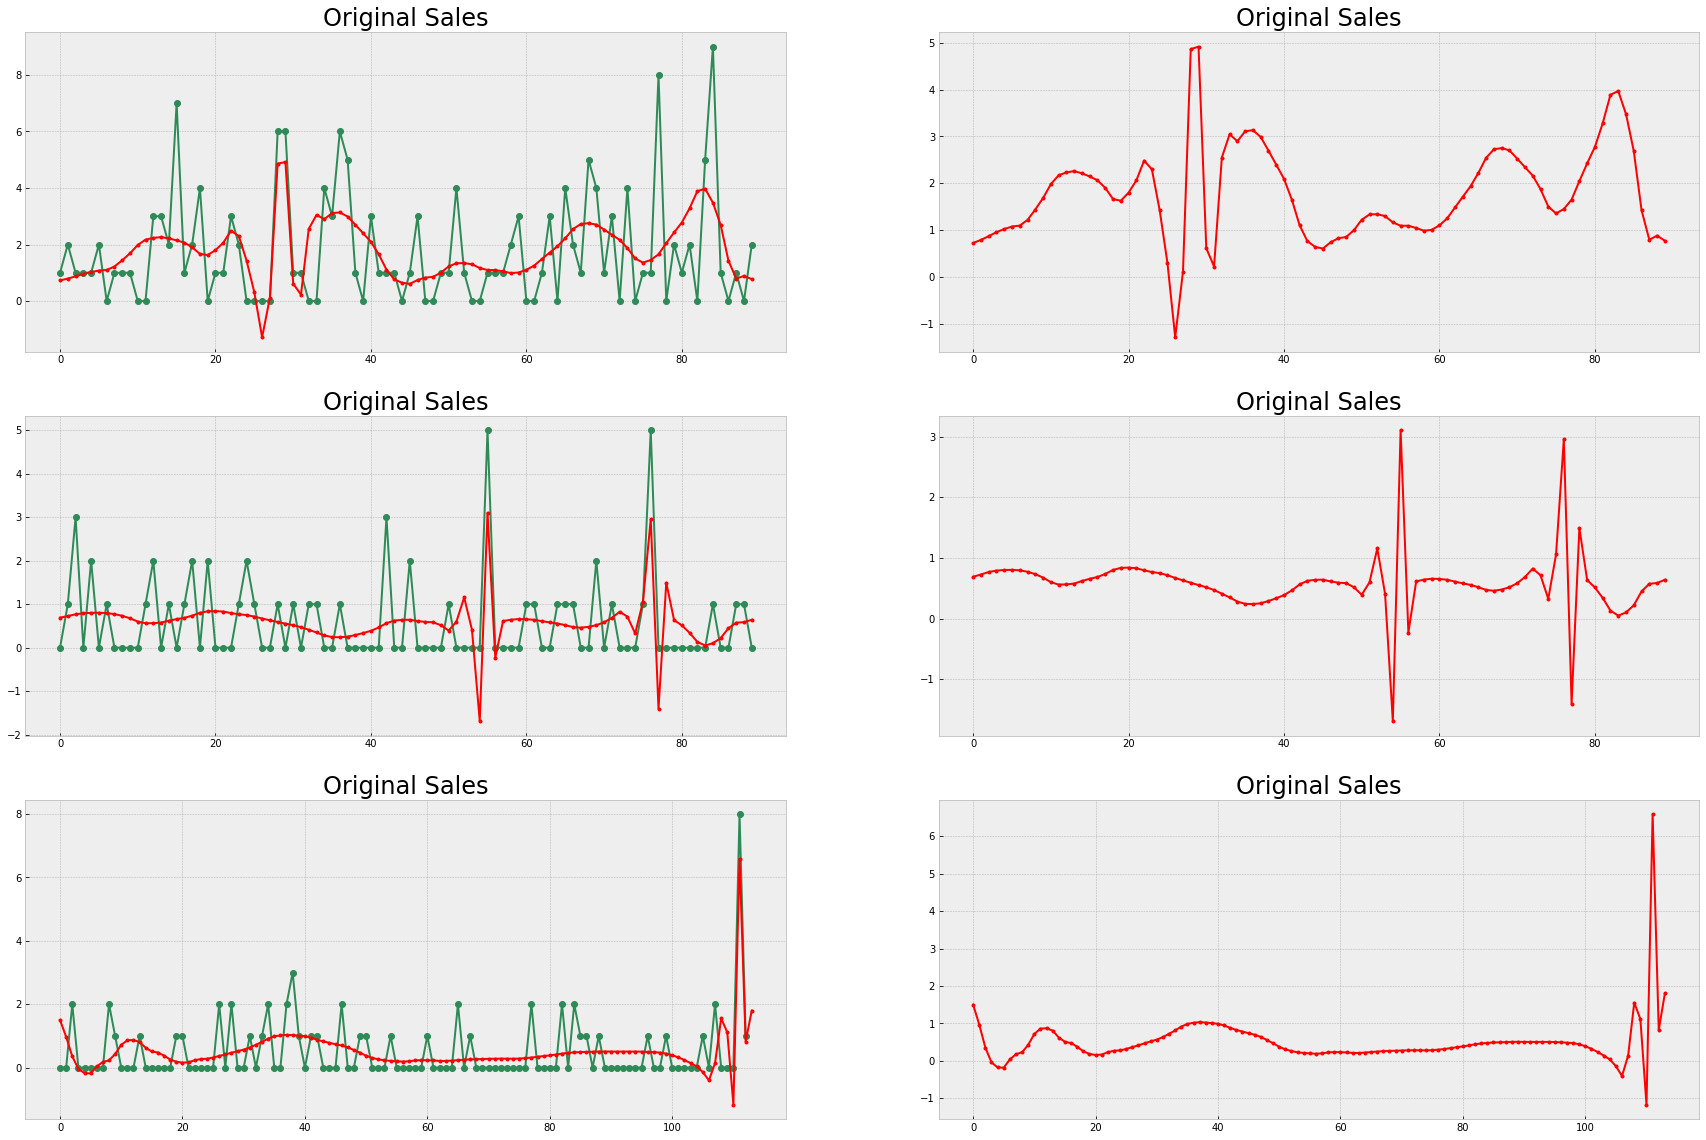

In [23]:
fig,ax=plt.subplots(nrows=3,ncols=2,figsize=(30,20))

ax[0,0].plot(x_1,color='seagreen',marker='o')
ax[0,0].set_title('Original Sales',fontsize=24)
ax[0,0].plot(y_w1,color='red',marker='.')
ax[0,0].set_title('Original Sales',fontsize=24)
ax[0,1].plot(y_w1,color='red',marker='.')
ax[0,1].set_title('Original Sales',fontsize=24)

ax[1,0].plot(x_2,color='seagreen',marker='o')
ax[1,0].set_title('Original Sales',fontsize=24)
ax[1,0].plot(y_w2,color='red',marker='.')
ax[1,0].set_title('Original Sales',fontsize=24)
ax[1,1].plot(y_w2,color='red',marker='.')
ax[1,1].set_title('Original Sales',fontsize=24)

ax[2,0].plot(x_3,color='seagreen',marker='o')
ax[2,0].set_title('Original Sales',fontsize=24)
ax[2,0].plot(y_w3,color='red',marker='.')
ax[2,0].set_title('Original Sales',fontsize=24)
ax[2,1].plot(y_w3,color='red',marker='.')
ax[2,1].set_title('Original Sales',fontsize=24)

fig.show()

### Average smoothing 均值平滑

均值平滑是一种相对简单的去噪时间序列数据的方法。在这种方法中，我们取一个固定大小的“窗口”（如10）。我们首先将窗口放在时间序列的开始处（前十个元素），然后计算该部分的平均值。我们现在在时间序列中向前移动一个特定的“步幅”，计算新窗口的平均值并重复这个过程，直到到达时间序列的末尾。然后，我们计算出的所有平均值被连接到一个新的时间序列中，形成去噪后的销售数据。

In [24]:
def average_smoothing(signal, kernel_size=3, stride=1):
    sample = [0]*(kernel_size-stride) # 通过 len(y_a1) 可以发现与原始数据同长度
    start = 0
    end = kernel_size
    while end <= len(signal):
        start = start + stride
        end = end + stride
        sample.extend([np.mean(signal[start:end])])
    return np.array(sample)

In [25]:
y_a1 = average_smoothing(x_1)
y_a2 = average_smoothing(x_2)
y_a3 = average_smoothing(x_3)

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_1)), mode='lines+markers', y=x_1, marker=dict(color="lightskyblue"), showlegend=False,
               name="Original sales"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_1)), y=y_a1, mode='lines', marker=dict(color="navy"), showlegend=False,
               name="Denoised sales"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_2)), mode='lines+markers', y=x_2, marker=dict(color="thistle"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_2)), y=y_a2, mode='lines', marker=dict(color="indigo"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_3)), mode='lines+markers', y=x_3, marker=dict(color="mediumaquamarine"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_3)), y=y_a3, mode='lines', marker=dict(color="darkgreen"), showlegend=False),
    row=3, col=1
)


fig.update_layout(height=1200, width=800, title_text="Original (pale) vs. Denoised (dark) signals")
fig.show()

在上面的图表中，暗线图表示去噪后的销售额，浅线图表示原始销售额。我们可以看到，平均平滑在发现数据中的宏观趋势和模式方面也很不错。

但是一般来说，小波去噪在寻找销售数据趋势方面显然更有效。尽管如此，平均平滑或“滚动平均”也可以用于计算建模的有用特征。

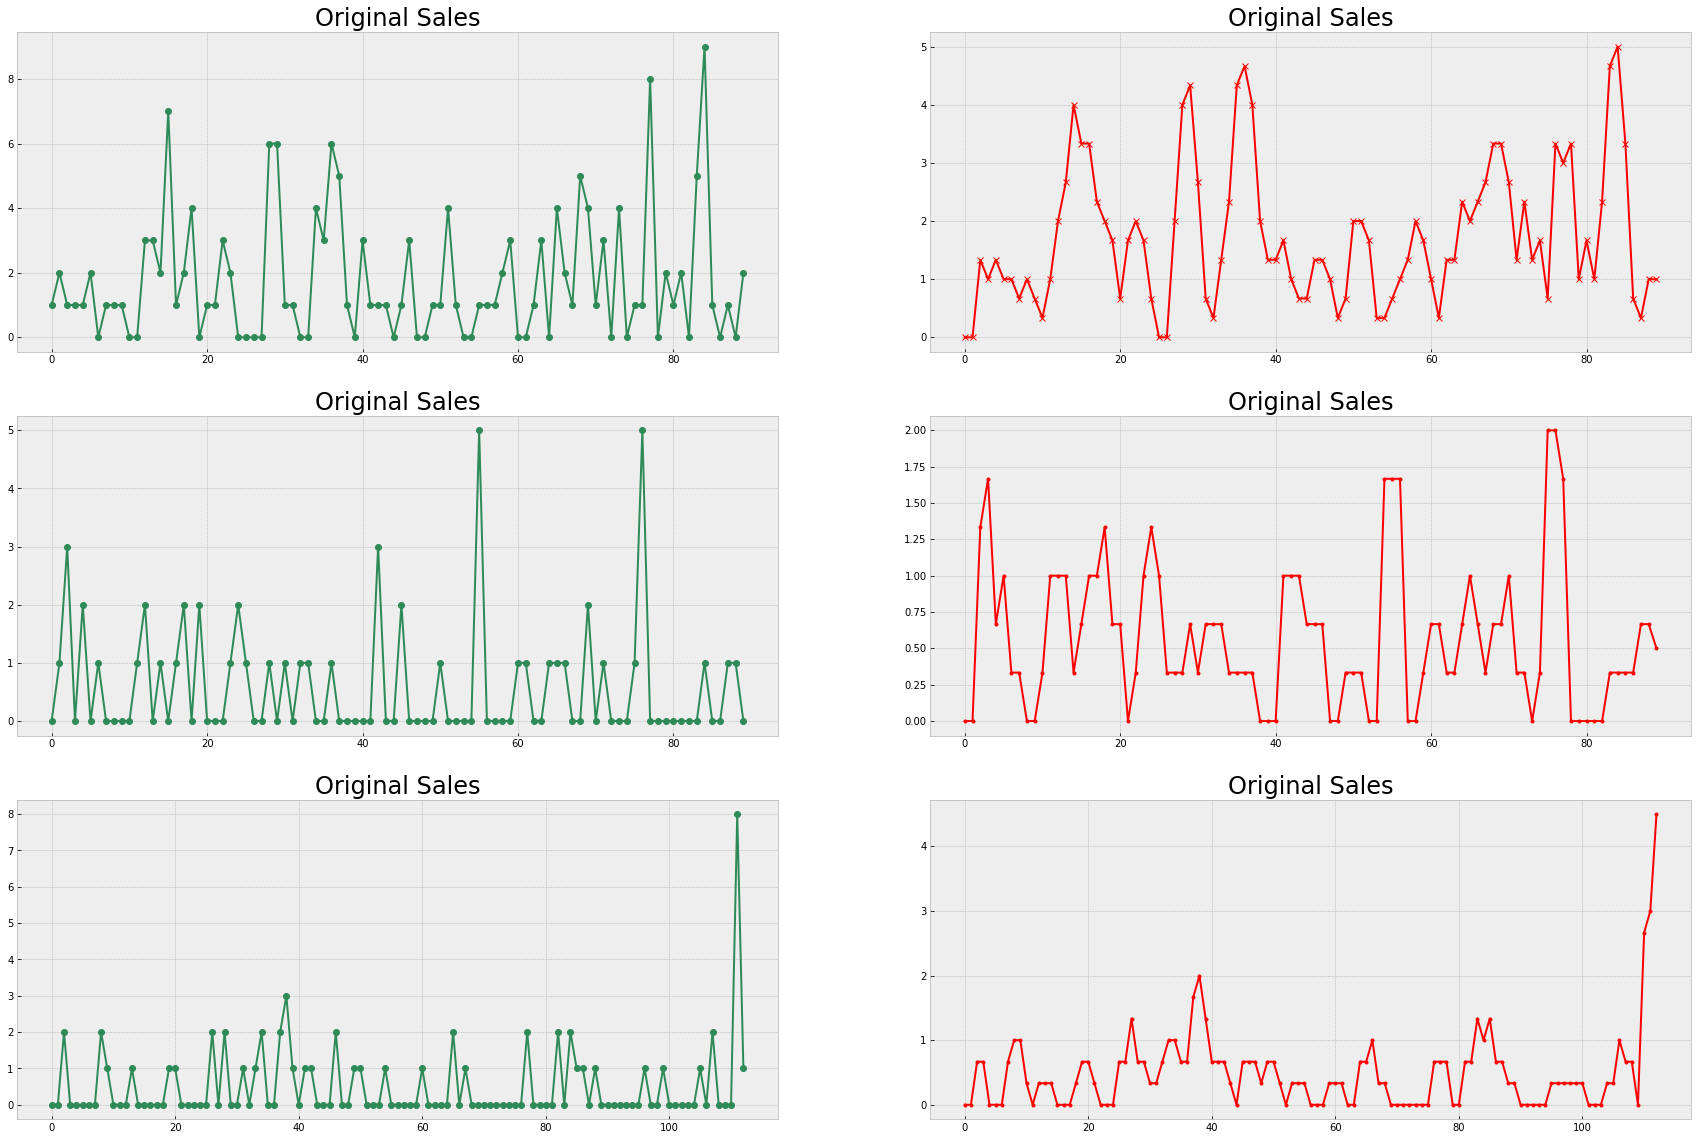

In [26]:
fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(30,20))

ax[0,0].plot(x_1,color='seagreen',marker='o')
ax[0,0].set_title('Original Sales',fontsize=24)
ax[0,1].plot(y_a1,color='red',marker='x')
ax[0,1].set_title('Original Sales',fontsize=24)

ax[1,0].plot(x_2,color='seagreen',marker='o')
ax[1,0].set_title('Original Sales',fontsize=24)
ax[1,1].plot(y_a2,color='red',marker='.')
ax[1,1].set_title('Original Sales',fontsize=24)


ax[2,0].plot(x_3,color='seagreen',marker='o')
ax[2,0].set_title('Original Sales',fontsize=24)
ax[2,1].plot(y_a3,color='red',marker='.')
ax[2,1].set_title('Original Sales',fontsize=24)

fig.show()

### Stores and states

接下来，我将查看不同商店和州的销售数据，以便获得一些有用的见解。

In [27]:
sales_train_validation.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  ...  d_1889  d_1890  d_1891  \
0     0     0     0     0     0     0     0  ...       0       0       0   
1     0     0     0     0     0     0     0  ...       0       0       0   
2     0     0     0     0     0     0     0  ...       0       0       0   
3     0     0     0     0     0     0     0  ...       0       3       1   
4     0     0     0     0     0     0     0  ...       4       0       1   

   d_1892  d_1893  d_1894  d_1895  d_1896  d_1897  d_1898  d_1899  d_1900  \
0       1       0       4       2       3       0       1       2       0   
1       0       0       0       0       0       0       0       0       0   
2       1       0       0       0       1       0       0       0       0   
3       2       1       3       1       0       2       5       4       2   
4       4       0       1       0       1       0       1       1       2   

   d_1901  d_1902  d_1903  d_1904  d_1905  d_1906  d_1907  d_1908  d_1909  \
0       0       0       1       1       3       0       1       1       1   
1       0       0       0       0       0       0       0       0       1   
2       0       1       2       2       1       2       1       1       1   
3       0       3       0       1       0       5       4       1       0   
4       0       1       1       2       1       1       0       1       1   

   d_1910  d_1911  d_1912  d_1913  
0       3       0       1       1  
1       0       0       0       0  
2       0       1       1       1  
3       1       3       7       2  
4       2       2       2       4  

[5 rows x 1919 columns]

In [28]:
sales_prices.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [29]:
calendar.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

#### 查看不同时间商品的销量情况

In [30]:
past_sales = sales_train_validation.set_index('id')[d_cols] \
            .T \
            .merge(calendar.set_index('d')['date'],left_index =True,right_index=True,).set_index('date')

store_list = sales_prices['store_id'].unique()
means = []

fig = go.Figure()

for s_id in  store_list:
    store_items = [s for s in past_sales.columns if s_id in s]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    means.append(np.mean(past_sales[store_items].sum(axis=1)))
    fig.add_trace(go.Scatter(x=data.index, y=data, name=s_id))
                 
fig.update_layout(yaxis_title='Sales',xaxis_title='Time',title='Rolling average Sales vs Time (per store)')

In [31]:
fig = go.Figure()
for s_id in  store_list:
    store_items = [s for s in past_sales.columns if s_id in s]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    fig.add_trace(go.Box(x=[s_id]*len(data), y=data, name=s_id))
fig.update_layout(yaxis_title='Sales',xaxis_title='Store',title='Rolling average Sales vs Store (per store)')

#### 各个商店所对应产品销售均值比较

In [32]:
fig = go.Figure()

# method 1
df = pd.DataFrame(np.transpose([means,store_list]))
df.columns=['Mean sales','Store name']
px.bar(df, y="Mean sales", x="Store name", color="Store name", title="Mean sales vs. Store name")

# method 2
# for i in np.transpose([means, store_list]):
#     fig.add_trace(go.Bar(y=[i[0]], x=[i[1]], marker = dict(color = next(color_cycle)),name=i[1]))
# fig.update_layout(yaxis_title="Mean Sales", xaxis_title="Store name", title="Mean Sales vs. Store name")

可以看出 CA_3 的平均销量最好，CA_4 平均销量最差

#### 不同时间下，不同产品数量的变化

In [33]:
cat_id_list = sales_train_validation['cat_id'].unique()

fig= go.Figure()

for cat_id in  cat_id_list:
    store_items = [s for s in past_sales.columns if cat_id in s]
    data = past_sales[store_items].sum(axis=1)
    fig.add_trace(go.Scatter(x=data.index,y=data,name=cat_id))
fig.update_layout(xaxis_title='time',yaxis_title='cat_id sales',title='cat_id Sales vs Time (per cat_id)')

商品在不同时间下出现的百分比次数

In [34]:
past_sales_clipped = past_sales.clip(0, 1)

fig = go.Figure()
for cat_id in  cat_id_list:
    store_items = [s for s in past_sales_clipped.columns if cat_id in s]
    data = past_sales_clipped[store_items].mean(axis=1) * 100
    fig.add_trace(go.Scatter(x=data.index,y=data,name=cat_id,mode='markers'))
fig.update_layout(xaxis_title='time',yaxis_title='% of Inventory with at least 1 sale',title='Inventory Sale Percentage by Date')

In [35]:
print('The lowest sale date was:', past_sales.sum(axis=1).sort_values().index[0],
     'with', past_sales.sum(axis=1).sort_values().values[0], 'sales')
print('The lowest sale date was:', past_sales.sum(axis=1).sort_values(ascending=False).index[0],
     'with', past_sales.sum(axis=1).sort_values(ascending=False).values[0], 'sales')

The lowest sale date was: 2012-12-25 with 11 sales
The lowest sale date was: 2016-03-06 with 57218 sales


可以看出在不同时间下，商品的数量也不一样，也就是说存在着有的商品退出了市场

## Modeling 开始建立模型

### ARIMA 

ARIMA 的英文全称是 Auto Regressive Integrated Moving Average 模型，中文叫 __差分自回归滑动平均模型__ ，也叫求合自回归滑动平均模型。相比于 ARMA，ARIMA 多了一个差分的过程，作用是对不平稳数据进行差分平稳，在差分平稳后再进行建模。ARIMA 的原理和 ARMA 模型一样。相比于 ARMA(p,q) 的两个阶数，ARIMA 是一个三元组的阶数 (p,d,q)，称为 ARIMA(p,d,q) 模型。其中 d 是差分阶数。


### SARIMAX

具有季节回归模型的季节性自回归综合移动平均线

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [45]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels

from tqdm import tqdm

### 划分训练集和测试集

In [46]:
store_sum = sales_train_validation.groupby(['store_id']).sum().T.reset_index(drop = True)
store_sum.head()

store_id    CA_1    CA_2    CA_3    CA_4    TX_1    TX_2    TX_3    WI_1  \
0         4337.0  3494.0  4739.0  1625.0  2556.0  3852.0  3030.0  2704.0   
1         4155.0  3046.0  4827.0  1777.0  2687.0  3937.0  3006.0  2194.0   
2         2816.0  2121.0  3785.0  1386.0  1822.0  2731.0  2225.0  1562.0   
3         3051.0  2324.0  4232.0  1440.0  2258.0  2954.0  2169.0  1251.0   
4         2630.0  1942.0  3817.0  1536.0  1694.0  2492.0  1726.0     2.0   

store_id    WI_2    WI_3  
0         2256.0  4038.0  
1         1922.0  4198.0  
2         2018.0  3317.0  
3         2522.0  3211.0  
4         1175.0  2132.0

In [105]:
train_datasets= store_sum.iloc[0:70]
val_datasets= store_sum.iloc[70:100]

#### seasonal_decompose

季节分解显示了一个时间序列在多大程度上表现出季节性和趋势性。这是一个很好的方式来考虑有多少销售是由于季节性，趋势，或一次性事件，如假日。

现在我们将使用每年一次的频率，直到我们做更详细的分析。

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose

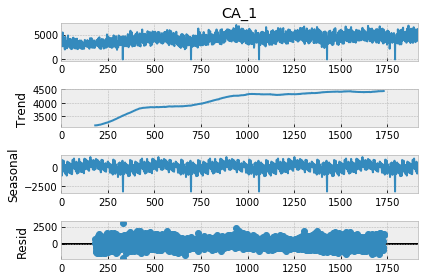

In [143]:
weeks_per_year = 365

time_series = store_sum["CA_1"]
sj_sc = seasonal_decompose(time_series, freq= weeks_per_year)
sj_sc.plot()

plt.show()

绘制其中某个商品在不同地区下的销售图像

In [120]:
fig = make_subplots(3,1)

fig.add_trace(go.Scatter(x=np.arange(70),y=train_datasets.iloc[:,0],marker=dict(color='seagreen'),name='Train'),row=1,col=1)
fig.add_trace(go.Scatter(x=np.arange(70,100),y=val_datasets.iloc[:,0],marker=dict(color='red'),name='Val'),row=1,col=1)

fig.add_trace(go.Scatter(x=np.arange(70),y=train_datasets.iloc[:,4],marker=dict(color='seagreen'), showlegend=False),row=2,col=1)
fig.add_trace(go.Scatter(x=np.arange(70,100),y=val_datasets.iloc[:,4],marker=dict(color='red'), showlegend=False),row=2,col=1)

fig.add_trace(go.Scatter(x=np.arange(70),y=train_datasets.iloc[:,7],marker=dict(color='seagreen'), showlegend=False),row=3,col=1)
fig.add_trace(go.Scatter(x=np.arange(70,100),y=val_datasets.iloc[:,7],marker=dict(color='red'), showlegend=False),row=3,col=1)

fig.update_layout(title='Sales volume of a commodity')

In [121]:
store_col = [0,4,7]

In [122]:
def sarima_train_test(t_series, p = 2, d = 1, r = 2, NUM_TO_FORECAST = 56, do_plot_results = True):
    
    NUM_TO_FORECAST = NUM_TO_FORECAST  # Similar to train test splits.
    dates = np.arange(t_series.shape[0])
    
    model = SARIMAX(t_series, order = (p, d, r), trend = 'c')
    results = model.fit()
#     results.plot_diagnostics(figsize=(12, 8))
#     plt.show()

    forecast = results.get_prediction(start = - NUM_TO_FORECAST)
    mean_forecast = forecast.predicted_mean
    conf_int = forecast.conf_int()

    print(mean_forecast.shape)

    # Plot the forecast
#     plt.figure(figsize=(6,4))
#     plt.plot(dates[-NUM_TO_FORECAST:],
#             mean_forecast.values,
#             color = 'red',
#             label = 'forecast')


#     plt.plot(dates[-NUM_TO_FORECAST:],
#             t_series.iloc[-NUM_TO_FORECAST:],
#             color = 'blue',
#             label = 'actual')
#     plt.legend()
#     plt.title('Predicted vs. Actual Values')
#     plt.show()
    
    residuals = results.resid # 模型的残差
    mae_sarima = np.mean(np.abs(residuals))
    print('Mean absolute error: ', mae_sarima)
    print(results.summary())
    return mean_forecast

In [127]:
predictions

array([[4011.09858315, 3587.72530969, 3953.37368006, 3928.62539123,
        4674.4018706 , 5050.37094154, 5150.19098112, 5089.27699103,
        3635.75189263, 3849.52249269, 4653.87006272, 4884.63435006,
        5747.08430512, 6151.61738645, 5069.46154285, 3543.32748221,
        3338.30643824, 3980.3243341 , 4499.38534591, 4726.6788012 ,
        5438.02974057, 5031.87857442, 3326.78413031, 3388.20780444,
        3981.83311001, 4381.9946496 , 4981.40353591, 5515.29482172],
       [4011.09858315, 3587.72530969, 3953.37368006, 3928.62539123,
        4674.4018706 , 5050.37094154, 5150.19098112, 5089.27699103,
        3635.75189263, 3849.52249269, 4653.87006272, 4884.63435006,
        5747.08430512, 6151.61738645, 5069.46154285, 3543.32748221,
        3338.30643824, 3980.3243341 , 4499.38534591, 4726.6788012 ,
        5438.02974057, 5031.87857442, 3326.78413031, 3388.20780444,
        3981.83311001, 4381.9946496 , 4981.40353591, 5515.29482172],
       [4011.09858315, 3587.72530969, 3953.373

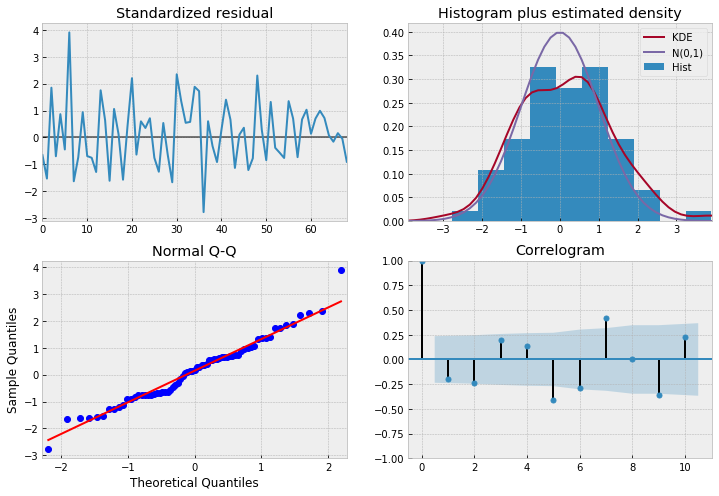

(28,)
Mean absolute error:  481.86861744974334
                               SARIMAX Results                                
Dep. Variable:                   CA_1   No. Observations:                   70
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -531.318
Date:                Wed, 15 Jul 2020   AIC                           1074.636
Time:                        18:18:30   BIC                           1088.041
Sample:                             0   HQIC                          1079.955
                                 - 70                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -34.7085     22.090     -1.571      0.116     -78.005       8.588
ar.L1          1.2396      0.025     49.125      0.000       1.190       1.289
ar.L2

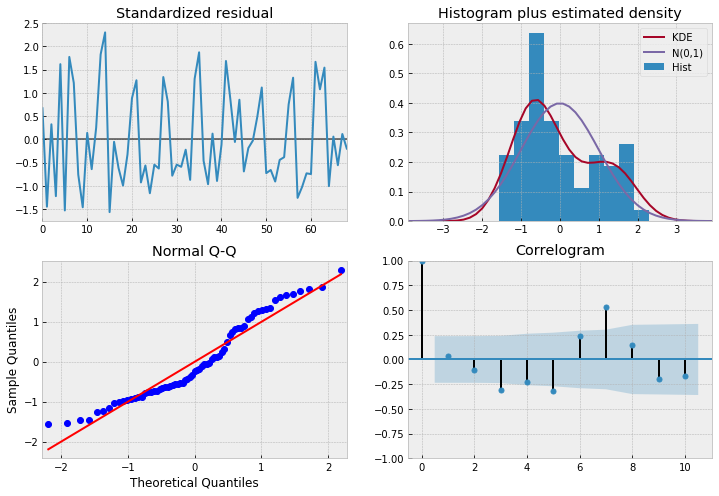

(28,)
Mean absolute error:  388.89860604148845
                               SARIMAX Results                                
Dep. Variable:                   TX_1   No. Observations:                   70
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -514.342
Date:                Wed, 15 Jul 2020   AIC                           1040.685
Time:                        18:18:31   BIC                           1054.089
Sample:                             0   HQIC                          1046.003
                                 - 70                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9228      5.895     -0.326      0.744     -13.476       9.631
ar.L1         -0.7441      0.146     -5.108      0.000      -1.030      -0.459
ar.L2

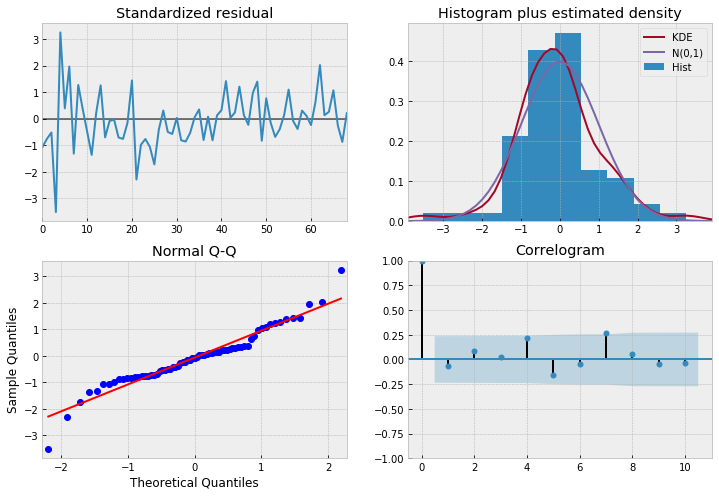

(28,)
Mean absolute error:  307.4636209158116
                               SARIMAX Results                                
Dep. Variable:                   WI_1   No. Observations:                   70
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -504.443
Date:                Wed, 15 Jul 2020   AIC                           1020.885
Time:                        18:18:32   BIC                           1034.290
Sample:                             0   HQIC                          1026.203
                                 - 70                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.1851      1.988     -0.596      0.551      -5.082       2.711
ar.L1          0.9858      0.089     11.080      0.000       0.811       1.160
ar.L2 

In [140]:
predictions = []

for col in store_col:
    predictions.append(sarima_train_test(train_datasets.iloc[:,col],NUM_TO_FORECAST=28))

predictions = np.array(predictions).reshape((-1, 28))

In [141]:
predictions

array([[3521.37051788, 3813.91363358, 3357.9572087 , 2340.63454977,
        2370.13750319, 2945.73530612, 3070.06742212, 3173.00315477,
        3782.38057311, 2990.11663904, 1903.01332141, 2240.63671298,
        2519.76888945, 3060.42976955, 3332.06601621, 3703.64339177,
        3087.47477526, 1885.72487674, 1814.94496738, 2519.12640494,
        3205.65082446, 3909.75464903, 4092.78543848, 3609.33021624,
        2849.92967486, 2535.42928558, 2995.57442635, 3672.5355444 ],
       [2106.57111641, 2389.47695414, 2300.74350805, 2264.02283839,
        2271.30671929, 2194.52373456, 2133.14251025, 2224.52535472,
        2211.51803914, 2373.50354039, 2129.2226026 , 2153.18840382,
        2041.07626797, 2140.00314389, 2084.64087886, 2273.49937876,
        2309.0843606 , 2126.4476686 , 2006.52650712, 2089.85204298,
        2014.90654963, 2340.46104847, 2287.3956534 , 2410.12566027,
        2095.52642436, 2194.69379389, 2084.42940211, 2191.29981353],
       [1862.18060024, 1835.09712325, 1305.421

In [142]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_datasets.iloc[:,0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_datasets.iloc[:,0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_datasets.iloc[:,4].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_datasets.iloc[:,4].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_datasets.iloc[:,7].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_datasets.iloc[:,7].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="ARIMA")
fig.show()

In [144]:
predict_data = pd.read_csv('./input/sample_submission.csv')

In [145]:
predict_data.head()

id  F1  F2  F3  F4  F5  F6  F7  F8  F9  F10  \
0  HOBBIES_1_001_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
1  HOBBIES_1_002_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
2  HOBBIES_1_003_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
3  HOBBIES_1_004_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
4  HOBBIES_1_005_CA_1_validation   0   0   0   0   0   0   0   0   0    0   

   F11  F12  F13  F14  F15  F16  F17  F18  F19  F20  F21  F22  F23  F24  F25  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   F26  F27  F28  
0    0    0    0  
1    0    0    0  
2    0    0    0  
3    0    0    0  
4    0    0    0